In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Sat Jan 27 00:19:50 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   51C    P0   167W / 300W |   8299MiB / 80994MiB |     22%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.latent.vqvae_latent import Latent
from model.decoder.net_64_decoder import Decoder
from model.no_module import NoModule

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.n_latents = 512
hp.z_dim = 64
hp.z_activation = F.tanh

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), NoModule(**hp), Latent(**hp), NoModule(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.0
latent 0.0
latent.bottle 0.0
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.21-1_3_tanh_warmstart/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 720000, model_list, optimizer_list)

total 0


In [8]:
path = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4/save_600000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))
# warm start
for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
    model.load_state_dict(checkpoint['models_state_dict'][i], strict=False)
    
print('done')

done


### Dataset

In [9]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [10]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [11]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [12]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

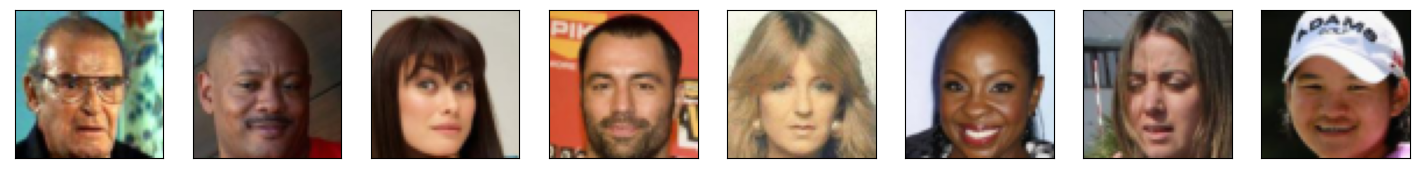

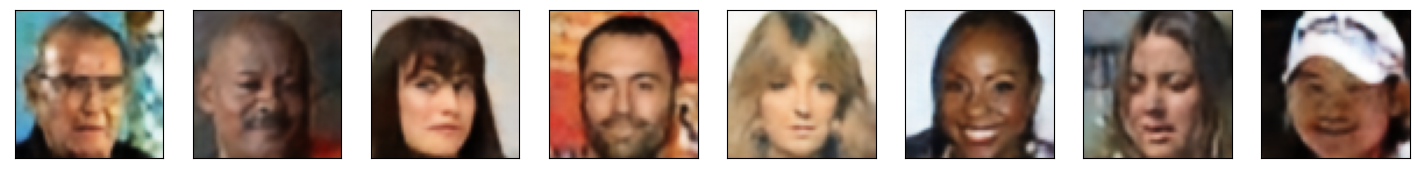

5001
commit_loss 0.0009294991032220423
recon_loss 0.0016262083081528544
5002
commit_loss 0.0009902098681777716
recon_loss 0.0019523686496540904
5003
commit_loss 0.0009631260181777179
recon_loss 0.0015405442100018263
5004
commit_loss 0.0009753595222719014
recon_loss 0.0016258549876511097
5005
commit_loss 0.0009643697994761169
recon_loss 0.001824607141315937
5006
commit_loss 0.001020575757138431
recon_loss 0.0017996354727074504
5007
commit_loss 0.0010386415524408221
recon_loss 0.0018483567982912064
5008
commit_loss 0.001020945142954588
recon_loss 0.0019228545716032386
5009
commit_loss 0.0009574067080393434
recon_loss 0.0016688922187313437
5010
commit_loss 0.0009220845531672239
recon_loss 0.001782492734491825
5011
commit_loss 0.0009663078817538917
recon_loss 0.001671193982474506
5012
commit_loss 0.0010147469583898783
recon_loss 0.0017202259041368961
5013
commit_loss 0.0009282303508371115
recon_loss 0.0016296440735459328
5014
commit_loss 0.0009885852923616767
recon_loss 0.00178795622196048

5117
commit_loss 0.0009362116106785834
recon_loss 0.001706315204501152
5118
commit_loss 0.0009441871661692858
recon_loss 0.0017549735493957996
5119
commit_loss 0.0009007962653413415
recon_loss 0.0017319065518677235
5120
commit_loss 0.0009518532897345722
recon_loss 0.0016420434694737196
5121
commit_loss 0.0009556490695104003
recon_loss 0.0017690767999738455
5122
commit_loss 0.0009093923727050424
recon_loss 0.0016864044591784477
5123
commit_loss 0.0010109830182045698
recon_loss 0.0019224899588152766
5124
commit_loss 0.0009951067622750998
recon_loss 0.001780624850653112
5125
commit_loss 0.0009080951567739248
recon_loss 0.0015650386922061443
5126
commit_loss 0.0010710898786783218
recon_loss 0.0017811608267948031
5127
commit_loss 0.0008981497958302498
recon_loss 0.0016268377657979727
5128
commit_loss 0.0009838598780333996
recon_loss 0.0016219293465837836
5129
commit_loss 0.0010448868852108717
recon_loss 0.0017977687530219555
5130
commit_loss 0.0010239516850560904
recon_loss 0.00181318155955

5233
commit_loss 0.0009489686344750226
recon_loss 0.0018899806309491396
5234
commit_loss 0.0009423002484254539
recon_loss 0.0016402227338403463
5235
commit_loss 0.001043347641825676
recon_loss 0.0018103941110894084
5236
commit_loss 0.0009443762246519327
recon_loss 0.0017533706268295646
5237
commit_loss 0.0009701498784124851
recon_loss 0.0017855344340205193
5238
commit_loss 0.0010075651807710528
recon_loss 0.001879341434687376
5239
commit_loss 0.0009477154235355556
recon_loss 0.0015723016113042831
5240
commit_loss 0.0009587614331394434
recon_loss 0.0018907550256699324
5241
commit_loss 0.0008977358229458332
recon_loss 0.0017294114222750068
5242
commit_loss 0.0009323051199316978
recon_loss 0.0015766611322760582
5243
commit_loss 0.0009189596748910844
recon_loss 0.001625765347853303
5244
commit_loss 0.0008717052405700088
recon_loss 0.0016358294524252415
5245
commit_loss 0.0009360224357806146
recon_loss 0.0017344485968351364
5246
commit_loss 0.0010017047170549631
recon_loss 0.001709054922685

5349
commit_loss 0.0009349939064122736
recon_loss 0.0018214031588286161
5350
commit_loss 0.0009669720893725753
recon_loss 0.001548280706629157
5351
commit_loss 0.000918748090043664
recon_loss 0.0018246106337755919
5352
commit_loss 0.0009771420154720545
recon_loss 0.0015829408075660467
5353
commit_loss 0.0009370170882903039
recon_loss 0.0017431932501494884
5354
commit_loss 0.0009071308886632323
recon_loss 0.001560209202580154
5355
commit_loss 0.0010197795927524567
recon_loss 0.0018189570400863886
5356
commit_loss 0.0009802010608837008
recon_loss 0.0017948707100003958
5357
commit_loss 0.0009370945044793189
recon_loss 0.0016862488118931651
5358
commit_loss 0.0010008270619437099
recon_loss 0.001724901027046144
5359
commit_loss 0.001025512581691146
recon_loss 0.0016624195268377662
5360
commit_loss 0.0009669299470260739
recon_loss 0.0019106295658275485
5361
commit_loss 0.0009043841273523867
recon_loss 0.0017465762794017792
5362
commit_loss 0.0009774689096957445
recon_loss 0.00183887197636067

5465
commit_loss 0.0010346947237849236
recon_loss 0.0016636498039588332
5466
commit_loss 0.0009122095652855933
recon_loss 0.001678602071478963
5467
commit_loss 0.0010377396829426289
recon_loss 0.0017197758425027132
5468
commit_loss 0.0009497592691332102
recon_loss 0.0016988887218758464
5469
commit_loss 0.0009688094723969698
recon_loss 0.0016352569218724966
5470
commit_loss 0.0009395815432071686
recon_loss 0.0016656204825267196
5471
commit_loss 0.000879673520103097
recon_loss 0.0015413013752549887
5472
commit_loss 0.0008632882963865995
recon_loss 0.0016295351088047028
5473
commit_loss 0.0009581180638633668
recon_loss 0.0019372956594452262
5474
commit_loss 0.0009305374696850777
recon_loss 0.0017484035342931747
5475
commit_loss 0.0009376740781590343
recon_loss 0.001682800124399364
5476
commit_loss 0.0008613415993750095
recon_loss 0.001604903256520629
5477
commit_loss 0.0008803883101791143
recon_loss 0.0016486283857375383
5478
commit_loss 0.0010469333501532674
recon_loss 0.0017738603055477

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            def get_entropy(zi):
                # (N, L)
                zi_onehot = F.one_hot(zi, num_classes=hp.n_latents)
                # (L)
                probs = zi_onehot.sum(dim=0) / len(zi_onehot)
                entropy = torch.sum(-probs * (torch.log(torch.clamp(probs, 1e-8)) - np.log(2)))
                return entropy

            entropy = get_entropy(data['zi']).item()
            writer.add_scalar('entropy', entropy, step)
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')